### 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

# boston 데이트 세트 로드
boston = load_boston()

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가함
bostonDF['PRICE'] = boston.target
print('Boston 데이터 세트 크기:',bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [2]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


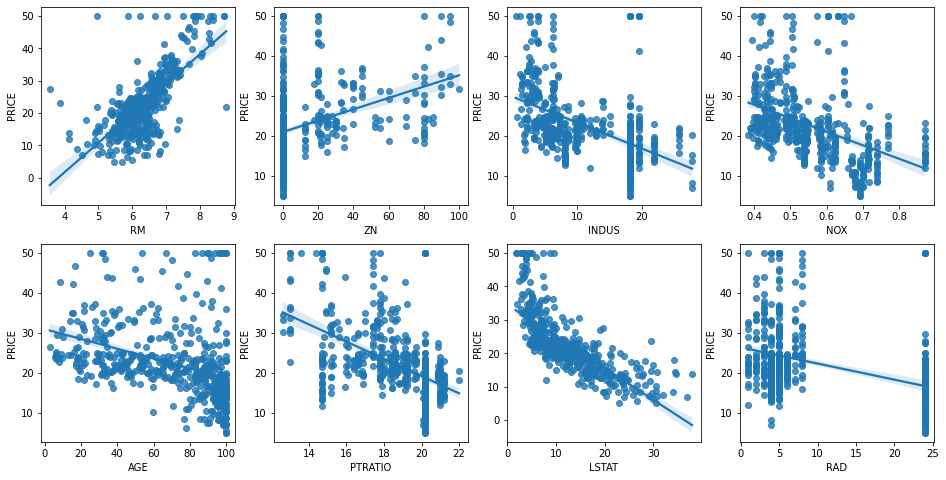

In [3]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,8) , ncols=4 , nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i , feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature , y='PRICE',data=bostonDF , ax=axs[row][col])

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
x_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_target,test_size=0.3, random_state=156)

# 선형 회귀 OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(x_train, y_train)
y_preds =lr.predict(x_test)
mse = mean_squared_error(y_test,y_preds)
rmse = np.sqrt(mse)

print('MSE:{0:.3f}, RMSE:{1:.3f}'.format(mse,rmse))
print('Variance score:{0:.3f}'.format(r2_score(y_test,y_preds)))

MSE:17.297, RMSE:4.159
Variance score:0.757


In [5]:
print('절편 값:', lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_,1))

절편 값: 40.995595172164336
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [6]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_,1), index=x_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [7]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
x_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

# cross_val_core()로 5폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함
neg_mse_scores = cross_val_score(lr, x_data, y_target, scoring='neg_mean_squared_error', cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수
print('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores, 2))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores, 2))
print('5 folds의 평균 RMSE:{0:.3f}'.format(avg_rmse)) 

5 folds의 개별 Negative MSE scores: [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE scores: [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE:5.829
